# Hydrostatic pressure channel

Note p ii: We also fix some analytical mistakes in p. i, in particular the stress is equation to minus the pressure (from the consituent equation), not positive. 

In this notebook we validate that the DDG pressure operator is working as expected by allow the compressive free flow of fluid parcels in the interior of a column starting at zero pressure, but with the accellertation due to gravity acting on the parcels.

In [1]:

import math
from scipy.spatial import Delaunay
#import polyscope as ps

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Imports and physical parameters
# std library

# plotting
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ddg imports
# Allow for relative imports from main library:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#from ddgclib._case1 import *
from ddgclib._capillary_rise import * #plot_surface#, curvature
from ddgclib._plotting import *

# compute duals (and Delaunay dual from a set of points)
from ddgclib.ddgclib.barycentric import compute_vd

# Plots
from ddgclib.ddgclib.barycentric import  plot_dual_mesh_2D

# Geometry and dual computations
from ddgclib.ddgclib.barycentric import plot_dual

# Boundary geometry                  
from ddgclib.ddgclib.barycentric import  _set_boundary


# Area computations

# Volume computations (including helper functions)


# DDG gradient operations on primary edges (for continuum)

def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points, dtype='float64')
    tri = Delaunay(points)
    return points


def plot_complex_3d_mat(points):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.spatial import Delaunay
    
    #np.random.seed(180)
    #points = np.random.rand(10, 3)
    
    tri = Delaunay(points)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2])
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(tri.simplices)))
    
    for i, s in enumerate(tri.simplices):
        tetrahedron = points[s]
        facets = [[tetrahedron[0], tetrahedron[1], tetrahedron[2]],
                  [tetrahedron[0], tetrahedron[1], tetrahedron[3]],
                  [tetrahedron[0], tetrahedron[2], tetrahedron[3]],
                  [tetrahedron[1], tetrahedron[2], tetrahedron[3]]]
        collection = Poly3DCollection(facets, alpha=0.1)
        face_color = colors[i]
        collection.set_facecolor(face_color)
        edge_color = (1, 1, 1)  # Make edges less visible
        collection.set_edgecolor(edge_color)
        ax.add_collection3d(collection)
    
        # Plot edges
        edges = [[tetrahedron[0], tetrahedron[1]],
                 [tetrahedron[0], tetrahedron[2]],
                 [tetrahedron[0], tetrahedron[3]],
                 [tetrahedron[1], tetrahedron[2]],
                 [tetrahedron[1], tetrahedron[3]],
                 [tetrahedron[2], tetrahedron[3]]]
        for edge in edges:
            ax.plot3D(*zip(edge[0], edge[1]), color='k', linewidth=0.5)

            

# General purpose functions:

### EOS

We use an EOS based on the bulk modulus $K=\rho \frac{d P}{d \rho} =-V \frac{d P}{d V}$, based on an atmospheric reference pressure:

$$P-P_0=K\left(\frac{\rho}{\rho_0}-1\right)$$

### Tait-Murnaghan
Another popular isothermal equation of state that goes by the name "Tait equation" $[7][8]$ is the Murnaghan model ${ }^{[9]}$ which is sometimes expressed as

$$
\frac{V}{V_0}=\left[1+\frac{n}{K_0}\left(P-P_0\right)\right]^{-1 / n}
$$

where $V$ is the specific volume at pressure $P, V_0$ is the specific volume at pressure $P_0, K_0$ is the bulk modulus at $P_0$, and $n$ is a material parameter.

Pressure formula
[edit]

This equation, in pressure form, can be written as

$$
P=\frac{K_0}{n}\left[\left(\frac{V_0}{V}\right)^n-1\right]+P_0=\frac{K_0}{n}\left[\left(\frac{\rho}{\rho_0}\right)^n-1\right]+P_0 .
$$


Specific volume as a function of pressure predicted by the Tai Murnaghan equation of state.
where $\rho, \rho_0$ are mass densities at $P, P_0$, respectively. For pure water, typical parameters are $P_0=101,325 \mathrm{~Pa}, \rho_0=1000 \mathrm{~kg} / \mathrm{cu} . \mathrm{I}$ $K_0=2.15 \mathrm{GPa}$, and $n=7.15$.

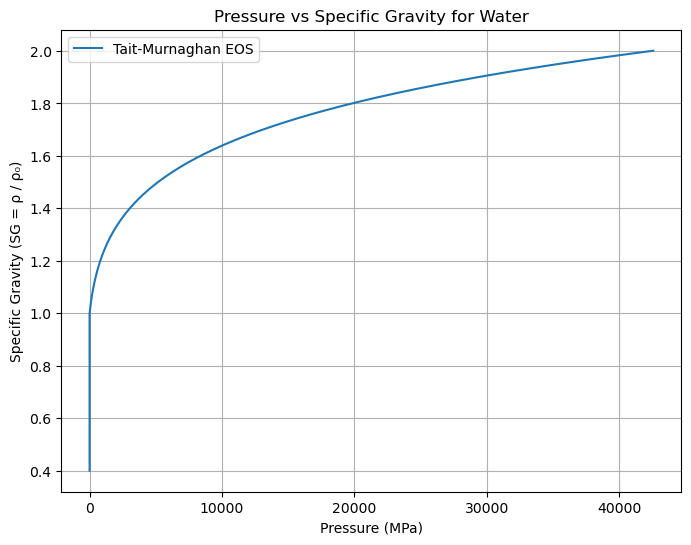

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def P_tait_murnaghan(rho, rho0=1000.0, P0=101325, K=2.15e9, n=7.15):
    """
    Computes the absolute pressure of water using the Tait-Murnaghan equation.

    Parameters:
    rho (float or array): Density of water in kg/m^3.
    rho0 (float): Reference density of water at room temperature (kg/m^3). Default: 1000.0.
    P0 (float): Reference pressure (Pa). Default: 101325 (atmospheric pressure).
    K (float): Bulk modulus parameter (Pa). Default: 2.2e9.
    n (float): Tait-Murnaghan parameter. Default: 7.15.

    Returns:
    float or array: Absolute pressure of water in Pascals (Pa).
    """
    st = (K / n) * ((rho / rho0)**n - 1)  # Second term
    pressure = P0 + np.max([np.zeros_like(st), st], axis=0)
    return pressure

# Generate data for plotting
rho_values = np.linspace(400, 2001, 100)  # Density range (kg/m^3)
P_values = P_tait_murnaghan(rho_values)   # Compute pressure
SG_values = rho_values / 1000.0           # Specific gravity

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(P_values / 1e6, SG_values, label='Tait-Murnaghan EOS')  # Convert pressure to MPa for readability
plt.title('Pressure vs Specific Gravity for Water')
plt.ylabel('Specific Gravity (SG = ρ / ρ₀)')
plt.xlabel('Pressure (MPa)')
plt.grid(True)
plt.legend()
plt.show()


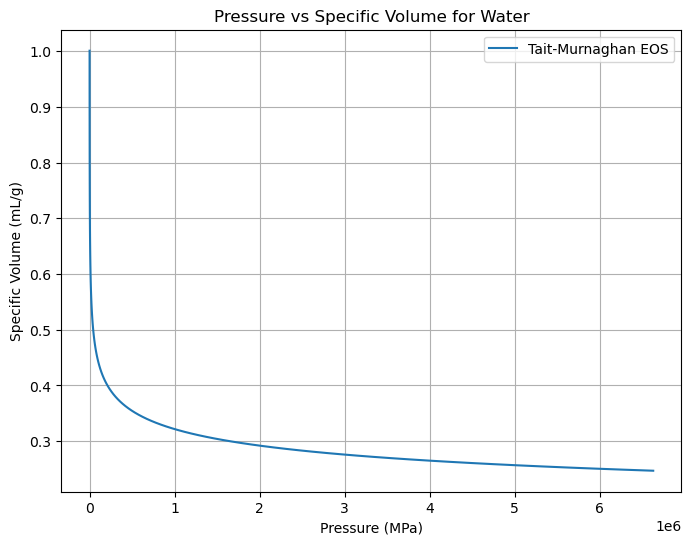

In [3]:
# Generate data
rho_values = np.linspace(999, 4050, 100)  # Density range (kg/m^3)
P_values = P_tait_murnaghan(rho_values)   # Compute pressure
specific_volume = 1 / rho_values          # Compute specific volume

# Plotting Pressure vs Specific Volume
plt.figure(figsize=(8, 6))
plt.plot(P_values / 1e6, specific_volume * 1e3, label='Tait-Murnaghan EOS')  # Convert specific volume to mL/g and pressure to MPa
plt.title('Pressure vs Specific Volume for Water')
plt.ylabel('Specific Volume (mL/g)')
plt.xlabel('Pressure (MPa)')
plt.grid(True)
plt.legend()
plt.show()

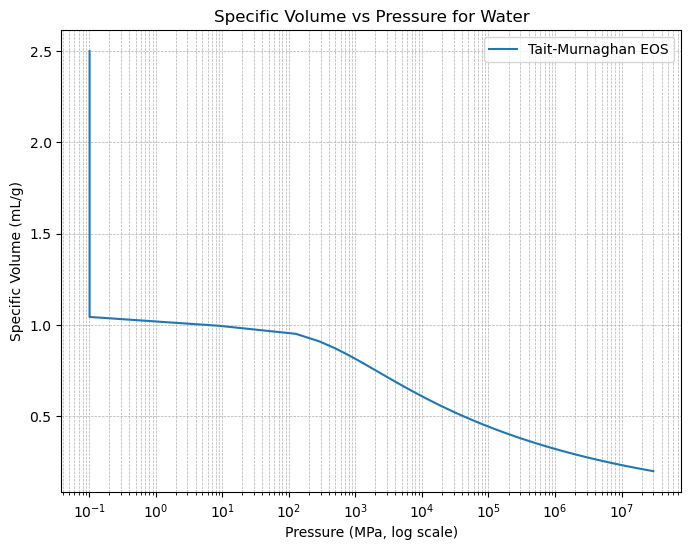

In [4]:
# Generate data
rho_values = np.linspace(400, 5000, 100)  # Density range (kg/m^3)
P_values = P_tait_murnaghan(rho_values)   # Compute pressure
specific_volume = 1 / rho_values          # Compute specific volume

# Plotting Pressure (log scale) vs Specific Volume (linear scale)
plt.figure(figsize=(8, 6))
plt.semilogx(P_values / 1e6, specific_volume * 1e3, label='Tait-Murnaghan EOS')  # Convert pressure to MPa, specific volume to mL/g
plt.title('Specific Volume vs Pressure for Water')
plt.xlabel('Pressure (MPa, log scale)')
plt.ylabel('Specific Volume (mL/g)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [5]:
import numpy as np
def P_eos_old(rho):
    """
    Computes the pressure of water at room temperature given density.
    
    Parameters:
    density (float): Density of water in kg/m^3.
    mass (float): Mass of the water in kg.
    
    Returns:
    float: Pressure of water in Pascals (Pa).
    """
    # Constants
    bulk_modulus = 2.2e9  # Bulk modulus of water at room temperature (Pa)
    rho0 = 1000.0  # Reference density of water at room temperature (kg/m^3)
    P_0 = 101325  # Pa
    
    # Pressure calculation using a simplified linearized bulk modulus relation
    pressure = bulk_modulus * ((rho / rho0) - 1) + P_0
    
    return pressure


P_eos = P_tait_murnaghan
# Example usage
P_0 = 101325  # Pa
rho_0 = 1000  # kg/m^3 (close to water's density at room temperature)
g = 9.81  # m/s^2, acceleration constant
mass = 1  # kg (arbitrary, as density is already independent of mass here)
pressure = P_eos(1000)
print(f"Pressure (atm): {pressure} Pa")
pressure = P_eos(1005)
print(f"Pressure (1005 kg/m3): {pressure} Pa  (Should be 11 MPa)")

# validation using https://www.engineeringtoolbox.com/water-temperature-specific-gravity-d_1179.html
# SG = rho / rho0  --> rho = SG * rho0

SG_range = np.linspace(0.9601, 1.00165)
rho_range = SG_range * rho_0   
# (Unfinished)

Pressure (atm): 101325.0 Pa
Pressure (1005 kg/m3): 11018032.296605485 Pa  (Should be 11 MPa)


# 1D 

Starting with the Cauchy momentum balance:

$$ \frac{D u}{D t} = \frac{1}{\rho} \nabla \cdot \sigma  + f_b $$

integrating both sides 

$$ \int_{\Omega} \frac{D u}{D t} dV =\int_{\Omega} \nabla \cdot \sigma  + \int_{\Omega}  \rho f_b dV $$

When we have zero mass fluxes across boundaries (i.e. our fluid parces with the advection set to zero:

$$ F_i = m_i a_i = m_i \frac{dv_i}{dt} = \int_{\Omega} \nabla \cdot \sigma  + \int_{\Omega}  \rho f_b dV $$



Suppose we could approximate purely invicid flow so that the only stress acting on a fluid volume parcel is the pressure 

$$ \nabla \cdot \sigma = \nabla -p $$

Integrating both sides:




$$ \int_{\Omega}  \nabla \cdot \sigma dV = -\int_{\Omega} \nabla p dV$$

To complete the integrated RHS, the gravity term is 

$$\int_{\Omega}  \rho F_g dV  = V_i \rho_i f_g = -V_i (\frac{m_i}{V_i}) f_g$$

Substitute $f_g = g$:

$$\int_{\Omega}  \rho F_g dV  = V_i \rho_i f_g = f_g$$


In 1D this reduces to the much more simple: 

$$ \frac{dv_i}{dt} = -\frac{1}{m_i} \int_{\Omega = C_i} \frac{d p}{ dx} dx + g $$

Where $C_i$ is the dual volume, from Stokes 
$$ \frac{dv_i}{dt} = -\frac{1}{m_i} \int_{\Omega = \partial C_i} \frac{d p}{ dx} dx + g $$

the ddg solution to the RHS is the simply (FTC):

$$ \frac{dv_i}{dt} = -\left(\frac{v_i - v_j}{||v_i - v_j||}\right) \cdot \frac{1}{m_i} \left( \sum^2_{j=0} p_j - p_i \right) = - n_{ij} \cdot  \frac{1}{m_i}  \left( \sum^2_{j=0} p_j - p_i \right)  $$

Where $j$ is the indices of the two points connected to vertex/dual parcel $i$. It is important to note the direction of $n_{ji}$, this is bcause the pressure is acting _inward_ on the fluid parcel. Ultimately we have to solve the coupled ODE for some finite timestep $\Delta t$:

\begin{align}
\frac{dv_i}{dt} =& -\frac{1}{m_i} \left( \sum^2_{j=0} p_j - p_i \right) + g \\
\frac{dx_i}{dt} =& v_i
\end{align}

The new position of course has the exact value:
$$x_i(t) = x_i^0 + v_i(t) t $$

where $x_i^0$ denotes the initial position. Later we will also see if we can find the time integrated ddg value for $d v_i$, this changes over time in a non-trivial way due to being coupled with neighbour dual values. There we would need to solve this of all of them at once with known dynamic pressure values $p_i(t)$ or at least the total integrated change in the values over a timestep.

# Interpretation in RTT and relation to Euler.

Copy-pasted from the wikipedia page this more closely builds on the machine precision Euler solution:

Integral derivation
[edit]

Applying Newton's second law (ith component) to a control volume in the continuum being modeled gives:

$$
m a_i=F_i
$$


Then, based on the Reynolds transport theorem and using material derivative notation, one can write

$$
\begin{aligned}
\int_{\Omega} \rho \frac{D u_i}{D t} d V & =\int_{\Omega} \nabla_j \sigma_i^j d V+\int_{\Omega} \rho f_i d V \\
\int_{\Omega}\left(\rho \frac{D u_i}{D t}-\nabla_j \sigma_i^j-\rho f_i\right) d V & =0 \\
\rho \frac{D u_i}{D t}-\nabla_j \sigma_i^j-\rho f_i & =0 \\
\frac{D u_i}{D t}-\frac{\nabla_j \sigma_i^j}{\rho}-f_i & =0
\end{aligned}
$$

where $\Omega$ represents the control volume. Since this equation must hold for any control volume, it must be true that the integrand is zero, from this the Cauchy momentum equation follows. The main step (not done above) in deriving this equation is establishing that the derivative of the stress tensor is one of the forces that constitutes $F_i \cdot{ }^{[1]}$

#### New derivations:

In 1D the equation reduces to  

$$\frac{Du}{Dt} - \frac{1}{\rho_i} \frac{\partial p_i}{\partial x} - f_i = 0$$
 
$$\left(\frac{\partial u_i}{\partial t} + u_i \cdot \frac{\partial u_i}{\partial x}\right)- \frac{1}{\rho_i} \frac{\partial p_i}{\partial x} - f_i = 0$$

For our control volume we also have $u_i = \frac{\partial x_i}{\partial t}$ and $\frac{\partial u_i }{\partial t} = \frac{\partial^2 x_i}{\partial t^2}$ 

Reynolds Transport Theorem (RTT) in a Nutshell:
The Reynolds Transport Theorem expresses the rate of change of a quantity $Q$ (like mass, momentum, or energy) within a control volume $V(t)$ that may change in time, due to the flow of the quantity through the boundary of the control volume.

Mathematically, it states:

$$
\frac{d}{d t} \int_{V(t)} \rho \Phi d V=\int_{V(t)} \frac{\partial}{\partial t}(\rho \Phi) d V+\int_{\partial V(t)} \rho \Phi \mathbf{v} \cdot \mathbf{n} d A
$$

where:
- $\quad \rho$ is the density of the quantity being transported (e.g., mass density for mass, or energy density for energy).
- $\Phi$ is the scalar field representing the quantity (e.g., temperature, velocity components, etc.).
- $V(t)$ is the control volume, which could be changing with time.
- $\partial V(t)$ is the boundary of the control volume.
- $\mathbf{v}$ is the velocity field of the fluid (the flow velocity of the quantity).
- $\mathbf{n}$ is the outward unit normal vector to the boundary.
- $d V$ is the volume element inside the control volume, and $d A$ is the surface area element on the boundary.

## Channel column test case

We assume the channel has dimension $1\times 1\times h$ and therefore we can divide the column with equal symmetric slices as if it's the real number line. Each dual fluid parcel then as an initial value $p_i = p_{atm}$ then under accelleration due to gravity the lower parcels should compress and the pressure will increase, the final values should then match $\rho g h$ at the centre of mass.

V = 0.625 m3
m = 625.0 kg
V = 0.625 m3
m = 625.0 kg
V = 1.25 m3
m = 1250.0 kg
V = 1.25 m3
m = 1250.0 kg
V = 1.25 m3
m = 1250.0 kg
V = 1.25 m3
m = 1250.0 kg
V = 1.25 m3
m = 1250.0 kg
V = 1.25 m3
m = 1250.0 kg
V = 1.25 m3
m = 1250.0 kg


/home/endres/projects/ddg/ddgclib/ddgclib/_complex.py:2906: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_complex.show()
/home/endres/projects/ddg/ddgclib/ddgclib/_complex.py:2911: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_surface.show()


(<ddgclib._complex.Complex at 0x7df596a05590>,
 [<ddgclib._vertex.VertexCube at 0x7df59ef4ddd0>])

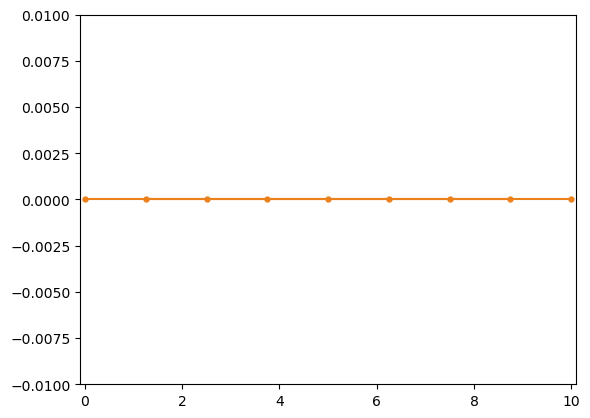

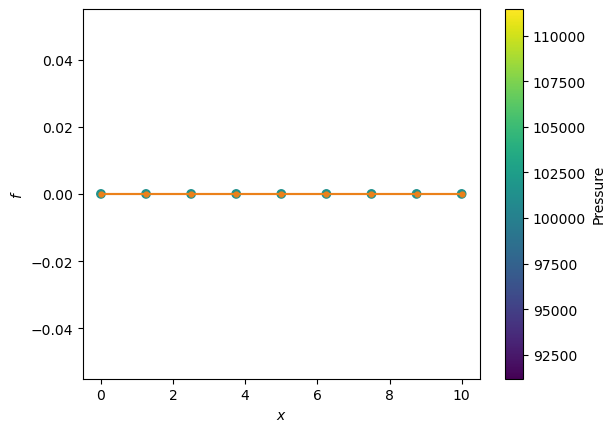

In [6]:
def init_1D_channel_column(h=10, refinement=0, plotting=False):
    # Initiate the complex
    HC = Complex(1, [[0, h]])
    HC.triangulate()
    for _ in range(refinement):
        HC.refine_all()
        
    #bV = [HC.V[(0,)], HC.V[(h,)]]  # Keep top vertex constant
    bV = [HC.V[(0,)]]  # Allow top vertex to move

    points = []
    p_scalar = []
    
    # Initiate pressure, density and add to plot points
    for v in HC.V:
        # The Initial pressure is just atmospheric pressure
        v.p = P_0
        # Set initial velocity static
        v.dv = 0
        # Find the initial "volume" length:
        V = 0  # Should be equal to 1/2 edge length in every direction
        for vn in v.nn:
            V += 0.5 * np.linalg.norm(vn.x_a - v.x)
        
        print(f'V = {V} m3')
        # The initial mass is based on 1x1xdx where dx is the vertex dual length
        v.m = rho_0 * V  # (kg/m3) * m3
        print(f'm = {v.m } kg')
        points.append(v.x_a)
        p_scalar.append(v.p)
    
    # Keep the bottom boundary condition at analytical
    HC.V[(0,)].p = P_0 + rho_0 * g * h
    
    if plotting:
        HC.plot_complex()
        points, p_scalar = (np.array(points), np.array( p_scalar))
        norm = plt.Normalize(p_scalar.min(), p_scalar.max())
        #plt.scatter(points, np.zeros_like(points), c=p_scalar, cmap='viridis', norm=norm)
        scatter = plt.scatter(points, np.zeros_like(points), c=p_scalar, cmap='viridis', norm=norm)
        plt.colorbar(scatter, label='Pressure')
        
    return HC, bV

init_1D_channel_column(h=10, refinement=2, plotting=True)

V = 0.625 m3
m = 625.0 kg
V = 0.625 m3
m = 625.0 kg
V = 1.25 m3
m = 1250.0 kg
V = 1.25 m3
m = 1250.0 kg
V = 1.25 m3
m = 1250.0 kg
V = 1.25 m3
m = 1250.0 kg
V = 1.25 m3
m = 1250.0 kg
V = 1.25 m3
m = 1250.0 kg
V = 1.25 m3
m = 1250.0 kg


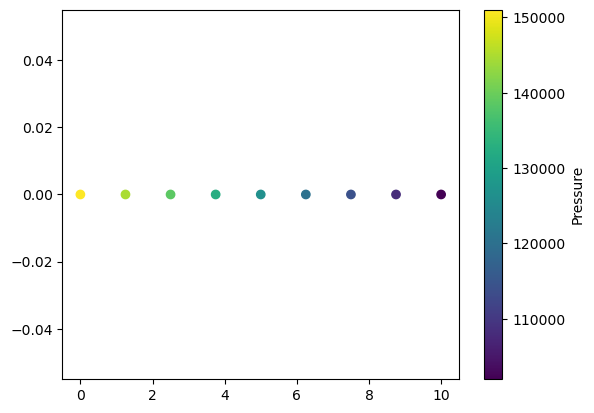

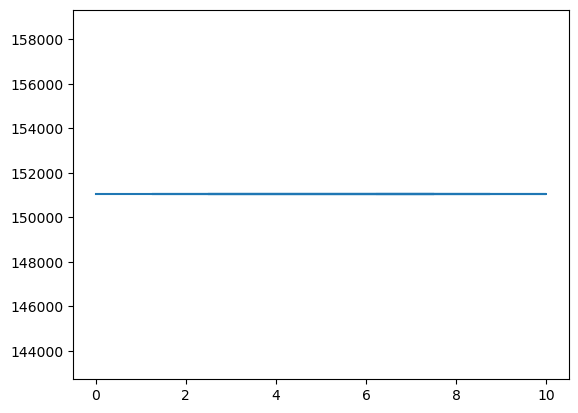

In [7]:
# Init
h = 10
HC, bV = init_1D_channel_column(h=h, refinement=2, plotting=False)

# Set pressure to equilibrium
if 0:
    for v in HC.V:
        v.p = P_0 + rho_0 * g * v.x_a[0] 
# Keep track of boundary vertices with persistent names:
v_bottom = HC.V[(0,)]
v_top = HC.V[(h,)]
#bV = [v_bottom, v_top]

# Time loop
#t = np.linspace(0, 1e-2, 30000)
t = np.linspace(0, 1e-3, 30000)
t = np.linspace(0, 1e-2, 3000)
t = np.linspace(0, 10, 30000)
dt = t[1]
    
for ti in t:
#for ti in t:
  #  print(f'-'*10)
  #  print(f't = {ti}')
    # Initiate pressure, density and add to plot points
    points = []  # reset for plotting
    p_scalar = []

    # Compute the current density and pressure:
    for v in HC.V:
    #    print(f'v.x = {v.x}')
        # Find the current volume
        V = 0  # m3, should be equal to 1/2 edge length in every direction
        for vn in v.nn:
            V += 0.5 * np.linalg.norm(vn.x_a - v.x)
            
        # Add the pressure from the density
     #   print(f'V = {V}')
    #    print(f'v.m = {v.m}')
        v.rho = v.m/V  # kg / m3
        v.p = P_eos(v.rho)  # pa
     #   print(f'v.rho  = {v.rho } ')
     #   print(f'v.p  = {v.p } ')
        
        # use the updated pressure 
        points.append(v.x_a)
        p_scalar.append(v.p)
    
    
    # Compute dp for every v:
    for v in HC.V:
        v.dp = 0
        for vn in v.nn:
            v.dp += -np.sign(vn.x_a[0] - v.x[0]) * (vn.p - v.p)
    # BC:
    # Keep the bottom boundary condition at analytical
    #HC.V[(0,)].p = P_0 + rho_0 * g * h
    #v_bottom.p = P_0 + rho_0 * g * h
    
    v_top.p = P_0  # Keep top vertex at atmospheric
    # Move the vertices
    for v in HC.V:
   #     print(f'-')
   #     print(f'v.x = {v.x}')
        # Keep boundaries constant?
        if v in bV:
            continue
        # dvdt 
        # TODO: Put in previous timestep velocity again: 
        #v.dv += (v.dp/v.m - g) * dt  
        v.dv = (v.dp/v.m - g) * dt
   #     print(f'v.dp = {v.dp}')
   #     print(f'/v.m = {1/v.m}')
   #     print(f'dp/v.m = {v.dp/v.m}')
   #     print(f'v.dv = {v.dv}')
   #     print(f'-g = {-g}')
        x_new = v.x_a + v.dv * dt
   #     print(f'x_new  = {x_new }')
        HC.V.move(v, tuple(x_new))

if 1:
    plt.figure()   
    plt.plot()
    points, p_scalar = (np.array(points), np.array( p_scalar))
    norm = plt.Normalize(p_scalar.min(), p_scalar.max())
    scatter = plt.scatter(points, np.zeros_like(points), c=p_scalar, cmap='viridis', norm=norm)
    plt.colorbar(scatter, label='Pressure')
    plt.figure()
    plt.plot(np.sort(points), p_scalar[np.argsort(points)])
    plt.show()

In [8]:
points = points.astype(np.float64).ravel()  
p_scalar = p_scalar.astype(np.float64).ravel()  

p_scalar[np.argsort(points)], np.sort(points), p_scalar[np.argsort(points)] - (P_0 + rho_0 * g * np.sort(points))

(array([151023.88717075, 144892.63715751, 138761.52961987, 132630.42206236,
        126499.45698045, 120368.49188529, 114237.66926574, 108106.84663956,
        101976.16648898]),
 array([0.        , 1.24997111, 2.49994934, 3.74992758, 4.99991294,
        6.24989831, 7.4998908 , 8.74988329, 9.99988292]),
 array([ 49698.88717075,  31305.42058784,  12912.02655386,  -5481.36749999,
        -23874.68900653, -42268.01052631, -60661.25950041, -79054.50848113,
        -97447.6849178 ]))

In [9]:
w=

SyntaxError: invalid syntax (1380076464.py, line 1)

# Older below

In [ ]:
# Init
h = 10
HC, bV = init_1D_channel_column(h=h, refinement=2, plotting=False)
# Keep track of boundary vertices with persistent names:
v_bottom = HC.V[(0,)]
v_top = HC.V[(h,)]
#bV = [v_bottom, v_top]

# Time loop
t = np.linspace(0, 1e-2, 3000)
t = np.linspace(0, 1, 30000)
dt = t[1]
    
#for ti in t[:2]:
for ti in t:
  #  print(f'-'*10)
  #  print(f't = {ti}')
    # Initiate pressure, density and add to plot points
    points = []  # reset for plotting
    p_scalar = []

    # Compute the current density and pressure:
    for v in HC.V:
    #    print(f'v.x = {v.x}')
        # Find the current volume
        V = 0  # m3, should be equal to 1/2 edge length in every direction
        for vn in v.nn:
            V += 0.5 * np.linalg.norm(vn.x_a - v.x)
            
        # Add the pressure from the density
     #   print(f'V = {V}')
    #    print(f'v.m = {v.m}')
        v.rho = v.m/V  # kg / m3
        v.p = P_eos(v.rho)  # pa
     #   print(f'v.rho  = {v.rho } ')
     #   print(f'v.p  = {v.p } ')
        
        # use the updated pressure 
        points.append(v.x_a)
        p_scalar.append(v.p)
    
    
    # Compute dp for every v:
    for v in HC.V:
        v.dp = 0
        for vn in v.nn:
            # Should be dp dotted with unit normal/"flux plane" direction
            #dp += -np.sign(vn.x_a[0] - v.x[0]) * (vn.p - v.p)
            #v.dp += -np.sign(vn.x_a[0] - v.x[0]) * (vn.p - v.p)
            v.dp += -np.sign(vn.x_a[0] - v.x[0]) * (vn.p - v.p)
    # BC:
    # Keep the bottom boundary condition at analytical
    #HC.V[(0,)].p = P_0 + rho_0 * g * h
    #v_bottom.p = P_0 + rho_0 * g * h
    
    v_top.p = P_0  # Keep top vertex at atmospheric
    # Move the vertices
    for v in HC.V:
   #     print(f'-')
   #     print(f'v.x = {v.x}')
        # Keep boundaries constant?
        if v in bV:
            continue
        # dvdt 
        v.dv += (v.dp /v.m - g) * dt
   #     print(f'v.dp = {v.dp}')
   #     print(f'/v.m = {1/v.m}')
   #     print(f'dp/v.m = {v.dp/v.m}')
   #     print(f'v.dv = {v.dv}')
   #     print(f'-g = {-g}')
        x_new = v.x_a + v.dv * dt
   #     print(f'x_new  = {x_new }')
        HC.V.move(v, tuple(x_new))

if 1:
    plt.figure()   
    plt.plot()
    points, p_scalar = (np.array(points), np.array( p_scalar))
    norm = plt.Normalize(p_scalar.min(), p_scalar.max())
    scatter = plt.scatter(points, np.zeros_like(points), c=p_scalar, cmap='viridis', norm=norm)
    plt.colorbar(scatter, label='Pressure')
    plt.figure()
    plt.plot(np.sort(points), p_scalar[np.argsort(points)])
    plt.show()

In [ ]:
points = points.astype(np.float64).ravel()  
p_scalar = p_scalar.astype(np.float64).ravel()  

p_scalar[np.argsort(points)], np.sort(points), p_scalar[np.argsort(points)] - (P_0 + rho_0 * g * np.sort(points))

In [ ]:
# Init
h = 10
HC, bV = init_1D_channel_column(h=h, refinement=2, plotting=False)
# Keep track of boundary vertices with persistent names:
v_bottom = HC.V[(0,)]
v_top = HC.V[(h,)]
#bV = [v_bottom, v_top]

# Time loop
#t = np.linspace(0, 1e-2, 30000)
t = np.linspace(0, 1e-3, 300)
#t = np.linspace(0, 1, 3000000)
#t = np.linspace(0, 1, 30000)
dt = t[1]
    
#for ti in t[:2]:
for ti in t:
  #  print(f'-'*10)
  #  print(f't = {ti}')
    # Initiate pressure, density and add to plot points
    points = []  # reset for plotting
    p_scalar = []

    # Compute the current density and pressure:
    for v in HC.V:
    #    print(f'v.x = {v.x}')
        # Find the current volume
        V = 0  # m3, should be equal to 1/2 edge length in every direction
        for vn in v.nn:
            V += 0.5 * np.linalg.norm(vn.x_a - v.x)
            
        # Add the pressure from the density
     #   print(f'V = {V}')
    #    print(f'v.m = {v.m}')
        v.rho = v.m/V  # kg / m3
        v.p = P_eos(v.rho)  # pa
     #   print(f'v.rho  = {v.rho } ')
     #   print(f'v.p  = {v.p } ')
        
        # use the updated pressure 
        points.append(v.x_a)
        p_scalar.append(v.p)
    
    
    # Compute dp for every v:
    for v in HC.V:
        v.dp = 0
        for vn in v.nn:
            # Should be dp dotted with unit normal/"flux plane" direction
            #dp += -np.sign(vn.x_a[0] - v.x[0]) * (vn.p - v.p)
            #v.dp += -np.sign(vn.x_a[0] - v.x[0]) * (vn.p - v.p)
            v.dp += np.sign(v.x[0] - vn.x_a[0]) * (vn.p - v.p)
    # BC:
    # Keep the bottom boundary condition at analytical
    #HC.V[(0,)].p = P_0 + rho_0 * g * h
    #v_bottom.p = P_0 + rho_0 * g * h
    
    v_top.p = P_0  # Keep top vertex at atmospheric
    # Move the vertices
    for v in HC.V:
   #     print(f'-')
   #     print(f'v.x = {v.x}')
        # Keep boundaries constant?
        if v in bV:
            continue
        # dvdt 
        v.dv += (v.dp/v.m - g) * dt
   #     print(f'v.dp = {v.dp}')
   #     print(f'/v.m = {1/v.m}')
   #     print(f'dp/v.m = {v.dp/v.m}')
   #     print(f'v.dv = {v.dv}')
   #     print(f'-g = {-g}')
        x_new = v.x_a + v.dv * dt
   #     print(f'x_new  = {x_new }')
        HC.V.move(v, tuple(x_new))

if 1:
    plt.figure()   
    plt.plot()
    points, p_scalar = (np.array(points), np.array( p_scalar))
    norm = plt.Normalize(p_scalar.min(), p_scalar.max())
    scatter = plt.scatter(points, np.zeros_like(points), c=p_scalar, cmap='viridis', norm=norm)
    plt.colorbar(scatter, label='Pressure')
    plt.figure()
    plt.plot(np.sort(points), p_scalar[np.argsort(points)])
    plt.show()

In [ ]:
points = points.astype(np.float64).ravel()  
p_scalar = p_scalar.astype(np.float64).ravel()  

p_scalar[np.argsort(points)], np.sort(points), p_scalar[np.argsort(points)] - (P_0 + rho_0 * g * np.sort(points))

In [ ]:
v.x_a

 # 2D

In [ ]:
def hydro_channel_points(domain, refinements=2, h=3):
    """
    Compute the triangulation of a 2D hydostatic column
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()
    
    # Build column    
    for i in range(1, h):
        for v in HC.V:
            v_new_t = copy.copy(v.x_a)
            v_new_t[1] += i
            v_new_t = tuple(v_new_t)
            v_new = HC.V[v_new_t]
            # Copy the neighbours
            for vn in v.nn:
                vn_new_t = copy.copy(vn.x_a)
                vn_new_t[1] += i
                vn_new_t = tuple(v_new_t)
                vn_new = HC.V[vn_new_t]
                v_new.connect(vn_new)

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points, dtype='float64')

    tri = Delaunay(points)
    return points


def hydro_channel(domain, refinements=2, h=3, cdist=1e-8):
    """
    Compute the triangulation of a 2D hydostatic column
    """
            
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()
        
    HCc = Complex(2, domain)
    HCc.triangulate()
    for i in range(refinements):
        HCc.refine_all()

    # Build column    
    for i in range(1, h):
        for v in HCc.V:
            vnnc = copy.copy(v.nn)
            v_new_t = copy.copy(v.x_a)
            v_new_t[1] += i
            v_new_t = tuple(v_new_t)
            v_new = HC.V[v_new_t]
            # Copy the neighbours
            for vn in vnnc:
                vn_new_t = copy.copy(vn.x_a)
                vn_new_t[1] += i
                vn_new_t = tuple(vn_new_t)
                vn_new = HC.V[vn_new_t]
                v_new.connect(vn_new)
                
    HC.bounds = [domain[0], (domain[1][0], h)]
    HC.V.merge_all(cdist)
    return HC

class _Tri_helper(object):
    """Helper class to define a tri object to return with .simplices 
    and .points properties"""
    def __init__(self, HC):
        HC.vertex_face_mesh()
        self.points = np.array(HC.vertices_fm)
        self.simplices = np.array(HC.simplices_fm_i)
        
#tri = _Tri_helper(HC)   
#tri.points, tri.simplices


# 2D

In [ ]:
h = 10  # height of column in meters
# Initial 
domain = [(0, 1),]*2
# Method to get regular mesh:
if 1:
    HC = hydro_channel(domain, refinements=0, h=3)
# Method to get Delaunay triangulated mesh:
if 0:
    points = hydro_channel_points(domain, refinements=0, h=3)
    HC, tri = triang_dual(points, plot_delaunay=True)

#HC.dim = 2
# NEW: Compute boundaries
bV = set()
for v in HC.V:
    if ((v.x_a[0] == 0.0 or v.x_a[1] == 0.0) or
        (v.x_a[0] == 1.0 or v.x_a[1] == h)):
        bV.add(v)
        
for bv in bV:
    _set_boundary(bv)
    
# Now compute duals as normal   
compute_vd(HC, cdist =1e-10)
HC.plot_complex()


In [ ]:
plt.plot()
tri = _Tri_helper(HC)   
points = tri.points
plot_dual_mesh_2D(HC, tri, points)

In [ ]:
for v in HC.V:
    print(v.x)

In [ ]:
print(HC.bounds)

In [ ]:
HC.plot_complex()

# Older caprise code below:

# 3 D


From the paper we expect to reach equilibrium after ∼0.05 s when using the parameters defined in the next cell:

In [ ]:
r_list = np.array([0.375, 0.5, 0.65]) * 1e-3  # m, Tube radii for 3 experiments
#r = 0.5#e-3  # mm (not m!), Default tube radius
r = r_list[1]  # mm (not m!), Default tube radius

gamma = 0.0728  # N/m, surface tension of water at 20 deg C
mu = 0.001  # Pa s, viscosity
rho = 997  # kg/m3, density

g = 9.81  # m/s2
# Parameters from EoS:
T_0 = 273.15 + 25  # K, initial tmeperature
P_0 = 101.325  # kPa, ambient pressure
#gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
theta_p = 9.99* np.pi/180.0  # Three-phase contact angle (degrees immediately converted to radius

# Initial condition
theta_i = 0#2*np.pi  #TODO: Doesn't really do anything yet unless equilibrium is set to True

# Jurin equilibrium height in m:
h_jurin = 2 * gamma * np.cos(theta_p) / (rho * g * r)
r*1e3, h_jurin *1e3

NOTE: From the paper we expect a rise time is roughly 0.3 s

The initial condition is atmospheric pressure at the bottom of the tube (assume the tube is "instantly" inserted and appears below the water line)

The rest of the pressure initial condition should follow rho g h increase.

Different boundary conditions will be explored.

In [ ]:
def _cap_rise_meniscus_init(r, theta_i, gamma, N=4, refinement=0,
                            cdist=1e-10, equilibrium=True):
    """
    Helper function to generate the initial film
    :param r: 
    :param theta_i: 
    :param gamma: 
    :param N: 
    :param refinement: 
    :return: 
    """
    Theta = np.linspace(0.0, 2 * np.pi, N)  # range of theta
    R = r / np.cos(theta_i)  # = R at theta = 0
    # Exact values:
    K_f = (1 / R) ** 2
    H_f = 1 / R + 1 / R  # 2 / R
    dp_exact = gamma * (2 / R)  # Pa      # Young-Laplace equation  dp = - gamma * H_f = - gamma * (1/R1 + 1/R2)
    F = []
    nn = []
    F.append(np.array([0.0, 0.0, R * np.sin(theta_i) - R]))
    nn.append([])
    ind = 0
    for theta in Theta:
        ind += 1
        # Define coordinates:
        # x, y, z = sphere(R, theta, phi)
        F.append(np.array([r * np.sin(theta), r * np.cos(theta), 0.0]))
        # Define connections:
        nn.append([])
        if ind > 0:
            nn[0].append(ind)
            nn[ind].append(0)
            nn[ind].append(ind - 1)
            nn[ind].append((ind + 1) % N)

    # clean F
    for f in F:
        for i, fx in enumerate(f):
            if abs(fx) < 1e-15:
                f[i] = 0.0

    F = np.array(F)
    nn[1][1] = ind

    # Construct complex from the initial geometry:
    HC = construct_HC(F, nn)
    v0 = HC.V[tuple(F[0])]
    # Compute boundary vertices
    V = set()
    for v in HC.V:
        V.add(v)
    bV = V - set([v0])
    for i in range(refinement):
        V = set()
        for v in HC.V:
            V.add(v)
        HC.refine_all_star(exclude=bV)
        # New boundary vertices:
        for v in HC.V:
            if v.x[2] == 0.0:
                bV.add(v)

    # Move to spherical cap
    for v in HC.V:
        z = v.x_a[2]
        z_sphere = z - R * np.sin(theta_i)  # move to origin
        # z_sphere = R * np.cos(phi)  # For a sphere centered at origin
        phi_v = np.arccos(z_sphere/R)
        plane_dist = R * np.sin(phi_v)
        # Push vertices on the z-slice the required distance
        z_axis = np.array([0.0, 0.0, z])  # axial centre
        vec = v.x_a - z_axis
        s = np.abs(np.linalg.norm(vec) - plane_dist)
        nvec = normalized(vec)[0]
        nvec = v.x_a + s * nvec
        HC.V.move(v, tuple(nvec))
        vec = nvec - z_axis
        np.linalg.norm(vec)

    # Rebuild set after moved vertices (appears to be needed)
    bV = set()
    for v in HC.V:
        if v.x[2] == 0.0:
            bV.add(v)

    if not equilibrium:
        # Move to zero, for mean flow simulations
        VA = []
        for v in HC.V:
            if v in bV:
                continue
            else:
                VA.append(v.x_a)

        VA = np.array(VA)
        for i, v_a in enumerate(VA):
            v = HC.V[tuple(v_a)]
            v_new = tuple(v.x_a - np.array([0.0, 0.0, v.x_a[2]]))
            HC.V.move(v, v_new)


    return F, nn, HC, bV, K_f, H_f


def cap_rise_init_dyn(r, theta_i, gamma, N=4, refinement=0, depth_dist=0.06, depth_ref=3, cdist=1e-12,
                    equilibrium=True):
    """
    
    :param r: 
    :param theta_i: Initial angle
    :param gamma: 
    :param N: 
    :param refinement: 
    :param cdist: 
    :param equilibrium: 
    :return: 
    """
    F, nn, HC, bV, K_f, H_f = _cap_rise_meniscus_init(r, theta_i, gamma, N, refinement, cdist=1e-12, equilibrium=False)
    
    # Save the points and boundary points
    V_points = []
    bV_points = []
    for v in HC.V:
        V_points.append(v.x_a)
    
    for bv in bV:
        print(f'bv.x_a = {bv.x_a}')
        bV_points.append(bv.x_a)
    
    V_points_film = np.array(V_points)
    bV_points_film = np.array(bV_points)
    print(f'V_points_film.shape = {V_points_film.shape}')
    print(f'bV_points_film.shape = {bV_points_film.shape}')
    # Extend the meniscus film down to a tube below the water line:
    dx = depth_dist/depth_ref
    h = 0  # Height layer tracker
    for i in range(depth_ref):
        # Add new points
        for v in V_points_film:
            v_new = copy.copy(v)
            v_new[2] = v_new[2] + h
            V_points.append(v_new)
            
        # Track new boundary points 
        for bv in bV_points_film:
            bv_new = copy.copy(bv)
            bv_new[2] = bv_new[2] + h
            bV_points.append(bv_new)
            
        h -= dx  # Update next layer height
        
    V_points = np.array(V_points)
    bV_points_a = np.array(bV_points)
    
    # Reconstruct the complex using these values:
    HC = Complex(3)
    for va in V_points:
        v = HC.V[tuple(va)]
        # Set default boundary off
        v.boundary = False

    
    tri = Delaunay(V_points)
    plot_complex_3d_mat(V_points)
    for t in tri.simplices:
        for v1i in t:
            v1a = V_points[v1i]
            v1 = HC.V[tuple(v1a)]
            for v2i in t:
                v2a =  V_points[v2i]
                v2 = HC.V[tuple(v2a)]
                v1.connect(v2)
    
    # Add boundary conditions:
    if 0:
        for vba in bV_points_a:
            vb = HC.V[tuple(vba)]
            vb.boundary = True
        
        # All the top and bottom points must also be boundary points (in the future use boundary function):
    
        h += dx  # Reset height to last layer in loop
        for v in V_points_film:
            v_new = copy.copy(v)
            v1 = HC.V[tuple(v_new)]
            v1.boundary = True
            v_new[2] = v_new[2] + h
            v2 = HC.V[tuple(v_new)]
            v2.boundary = True
            bV_points.append(v1.x_a)
            bV_points.append(v2.x_a)
    
        bV_points = np.array(bV_points)
        print(f'V_points.shape = {V_points.shape}')
        print(f'bV_points.shape = {bV_points.shape}')
    
    # Clean up:
    HC.V.merge_all(cdist)
    
    bV = set()
    for vba in bV_points:
        vb = HC.V[tuple(vba)]
        bV.add(vb)
    print(f'bV = {bV}')
    return HC, bV


def cube_to_tube(r, refinements=1, height=5e-3):
    # Construct the initial cube 
    lb = -0.5
    ub = 0.5
    domain = [(lb, ub),]*3
    #symmetry = [0, 1, 1]
    HC = Complex(3, domain=domain, symmetry=None)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()
    
    # NEW
    # Compute boundaries
    bV = set()
    for v in HC.V:
        if ((v.x_a[0] == lb or v.x_a[1] == lb or v.x_a[2] == lb) or
            (v.x_a[0] == ub or v.x_a[1] == ub or v.x_a[2] == ub)):
            bV.add(v)
            
    # boundaries which exclude the interior vertices on the top/bottom of
    # the cyllinder
    bV_sides = set()
    for v in HC.V:
        #if ((v.x_a[0] == lb or v.x_a[0] == ub) and
        #    (v.x_a[1] == lb or v.x_a[1] == ub)):
        if ((v.x_a[0] == lb or v.x_a[0] == ub) or
            (v.x_a[1] == lb or v.x_a[1] == ub)):
            bV_sides.add(v)
            # Special side boundary property
            v.side_boundary = True
        else:
            v.side_boundary = False
    #print(f'bV_sides = {bV_sides}')
    
    for bv in bV:
        _set_boundary(bv, True)
    for v in HC.V:
        if not (v in bV):
            _set_boundary(v, False)

    #for bv in bV:
    #    print(f'bv = {bv.x}')
    # Move the vertices to the tube radius
    for v in bV_sides:
        r_eff = r  # Trancated radius projection   
        nv = np.zeros(3)
        theta = math.atan2(v.x_a[1], v.x_a[0])
        nv[0] = r_eff * np.cos(theta)
        nv[1] = r_eff * np.sin(theta)
        if 1:
            h_eff = height #* ((1 - np.cos(np.pi * v.x[2]**0.5)) / 2)
        nv[2] = h_eff * (v.x[2] - 0.5) #* 1e-3
        print(f'nv[2] = {nv[2]}')
        HC.V.move(v, tuple(nv))
    
    for v in HC.V:
        #if v.boundary:
        if v.side_boundary:
            continue
        d = np.linalg.norm(v.x_a[:2])  # This is already a normalized distance for 0.5 bounds
        # Power law scaling:
        if 0:
            n = 0.5 # 0.6  # Aribtrarily chosen power law scaling, should be n<=r 
            r_eff = d**n * r  # Trancated radius projection   
        # log law scaling:
        if 0:
             r_eff = r * (np.log(d + 1) / np.log(2))
        # Sinusoidal scaling:
        if 1:
            r_eff = (r * ((1 - np.cos(np.pi * d**0.5)) / 2))
            
        #r_eff = r/d  # Trancated radius projection   
        nv = np.zeros(3)
        theta = math.atan2(v.x_a[1], v.x_a[0])
        nv[0] = r_eff * np.cos(theta)
        nv[1] = r_eff * np.sin(theta)
        # Height scaling
        if 1:
            h_eff = height #* ((1 - np.cos(np.pi * v.x[2]**0.5)) / 2)
            
            
        nv[2] = h_eff * (v.x[2] - 0.5) #* 1e-3
        print(f'nv[2] = {nv[2]}')
        HC.V.move(v, tuple(nv))
        
    #print(f'post move:')
    #for bv in bV:
    #    print(f'bv = {bv.x}')
    return HC

In [ ]:
r, r * 0.5e1

In [ ]:
ps.remove_all_structures()

In [ ]:
# Initiation
%matplotlib notebook
import polyscope as ps
if 0:
    r = 0.5
 
height = r * 0.5e1
#height = 0.5
HC = cube_to_tube(r, refinements=1, height=height)

#HC.plot_complex()

# Compute the initial duals
compute_vd(HC, cdist=1e-8)

# Plot the initial complex
if 0:
    #vi = HC.V[(0.0, 0.0, 0.0)]
    #vi = HC.V[(0.5, 0.0, 0.0)]  # Vertex No. 17
    vi = HC.V[(0.5e-3, 0.0, 0.0)]  # Vertex No. 17
    #vi = HC.V[(0.3535533905932738, 0.35355339059327373, 0.5)]
    print(f'vi.x = {vi.x}')
    #plot_dual(vi, HC, length_scale=1e3, point_radii=1e-5)
    length_scale = 1e-3
    plot_dual(vi, HC, length_scale=length_scale, 
                      point_radii=1e-5)
    ps.look_at((0., -10.*length_scale, 0.), (0., 0., 0.))  # Side
    ps.look_at((0., -10.*length_scale, 2.*length_scale), (0., 0., 0.))  # Side raise
    #ps.show()
    #ps.remove_surface_mesh("Dual face")
    ps.remove_all_structures()


In [ ]:
# Move some vertices:
if 1: # Turn off for testing
    vi = HC.V[(0.0, 0.0, 0.0)]
    #vi = HC.V[(0.3535533905932738, 0.35355339059327373, 0.5)]
    vt_new = (0.0, 0.0, (0.5 + 2e-1)*1e-3)
    v_new = HC.V.move(vi, vt_new)
    vi = v_new 
    
    # Postprocessing
    HC.V.merge_all(1e-12)
    # Clear the dual cache
    for v in HC.V:
        v.vd = set()
      
    HcVd = copy.copy(HC.Vd)
    for vd in HcVd:
        HC.Vd.cache.pop(vd.x)
    
    # Recompute the dual:
    compute_vd(HC, cdist=1e-7)
        
    # Plot the final complex
    if 1:
        plot_dual(vi, HC, length_scale=length_scale, 
                      point_radii=1e-5)
        ps.look_at((0., -10.*length_scale, 0.), (0., 0., 0.))  # Side
        ps.look_at((0., -10.*length_scale, 2.*length_scale), (0., 0., 0.))  #

        #ps.show()
        #ps.remove_surface_mesh("Dual face")
        ps.remove_all_structures()
        